**ML COURSE 2024-2025**
# LAB3: LASSO REGRESSION

In this notebook you will implement gradient descent with LASSO regularization, and Nested K-fold Cross Validation.

#### Summary
- Part 1: Implementation and visualization of gradient descent algorithm.
- Part 2: Recap on LASSO, LASSO regularization using gradient descent.
- Part 3: Hyperparameter tuning, Nested K-Fold Cross Validation.

## Gradient Descent

<!--Since the Lasso regression does not have a closed form solution, we need to use an optimization algorithm to find the coefficients that minimize the loss function.-->

The gradient descent algorithm is an iterative optimization algorithm that updates the coefficients in the opposite direction of the gradient of the loss function.

The update rule for the coefficients is given by:

$$
\beta_{new} = \beta - \alpha \; \nabla_\beta J(\beta)
$$

Where
- $\eta$ is the learning rate
- $\nabla_\beta J(\beta)$ is the gradient of the loss function
- $\beta_{new}$ is the updated coefficients

**That may be a bit to digest, but don't worry! Let's get an intuition step by step.**

#### First of all, what is the gradient?

Maybe this sentence is familiar:

> The gradient is a vector that points in the direction of the steepest increase of a scalar function.

Note that the the gradient is a vector that lives in the input space! In our case, the space of the coefficients.

In [12]:
!git clone https://github.com/AMCO-UniPD/ML_lab_DEI_public.git

fatal: destination path 'ML_lab_DEI_public' already exists and is not an empty directory.


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append("ML_lab_DEI_public")
from utils import plot_gradient_1d, plot_gradient_2d


plot_derivative(f, df, t="Quadratic function")

np.random.seed(0)

In [14]:
# This is our function, it could be anything, but in this case it's a simple quadratic function
def f(x):
    return (x**2) * 0.1


# This is the derivative of the function, good old calculus remember?
def df(x):
    return (2 * x) * 0.1

We can visualize the derivative as the slope of a function at a given point.

In [15]:
plot_derivative(f, df, t="Quadratic function")

In [16]:
# we can also try with a different function
plot_derivative(np.sin, np.cos, x=np.linspace(-2*np.pi, 2*np.pi, 100), t="Sine function", n=7)

If the gradient lives in the input space, it means that in this $\mathbb{R}^1 \rightarrow \mathbb{R}^1$ case, the gradient is a 1D vector along the x-axis.

In [17]:
plot_gradient_1d(f, df, x=np.linspace(-10, 10, 100), n=10)

This plot shows arrows that start at a certain point along the x, and their length depends on the slope of the function at that point.

Unlike other visualizations, this one shows the gradient as a vector in the input space, meaning along the x axis.

Other visualizations may show the gradient as a vector that follows the function curve, but that may be misleading when first learning about gradients.

Now we are redy to increase the dimensions! Let's see a function that has 2 input variables.

In [18]:
def f(x1, x2):
    return (x1**2 + x2**2) * 0.1

# this time the function has two variables, so we need to calculate the partial derivatives
def df(x1, x2):
    return np.array([2*x1, 2*x2]) * 0.1

The scalar function we want to plot is: $f(x, y) = x^2 + y^2, \; f: \mathbb{R}^2 \to \mathbb{R}$

- remember that the input variables lie in the horizontal plane
- The output of the function is the "height" of the surface
- The color is also the output of the function

In [19]:
from utils import plot_gradient_2d

plot_gradient_2d(f, df, follow_surface=False)

We can also visualize the gradient as vectors that follow the surface of the function, as it is a common way to visualize gradients, but remember what we said about the gradient living in the input space.

In [20]:
plot_gradient_2d(f, df, follow_surface=True)

In [21]:
lambda_ = 10

def f_lasso(x1, x2):
    mse = (x1**2 + x2**2)
    penalty = lambda_ * (np.abs(x1) + np.abs(x2))
    return 0.1 * (mse + penalty)

def df_lasso(x1, x2):
    d_mse = np.array([2*x1, 2*x2])
    d_penalty = lambda_ * np.array([np.sign(x1), np.sign(x2)])
    return 0.1 * (d_mse + d_penalty)

plot_gradient_2d(f_lasso, df_lasso, follow_surface=False)

## LASSO

LASSO requires to find coefficients which solves the following minimization problem:

$$
\begin{aligned}
\beta &= \arg \min_{\beta} J(\beta) \\
& = arg \min_{\beta} \left[ \sum_{i=1}^{n} \left( y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij} \right)^2 + \lambda \sum_{j=\textcolor{red}{1}}^{p}|\beta_j|\right] \\
\end{aligned}
$$

<div style="background-color: lightblue; padding: 10px; color: black">
    <strong> 🚫 Warning! </strong>
    In LASSO, as in Ridge Regression, do <strong>NOT</strong> penalize the bias term β₀.
</div>


Let:
- $\mathbf{X}$ be the expanded input matrix, with the column of 1s to account for the bias term.
- $\beta \doteq [\beta_0, \beta_1, ..., \beta_p]^T \in \mathbb{R}^{p+1}$, with the bias term included.

Then, the optimization problem can be rewritten in matrix form:  
$$
\beta = \arg \min_{\beta} \left[ (\mathbf{y} - \mathbf{X} \beta)^2  + \lambda L_1 \right]
$$

where:
$$
L_1  = \sum_{j=\textcolor{red}{1}}^{p}|\beta_j| \doteq |\beta_1| + ... + |\beta_p|
$$
</div>

<div style="background-color: lightblue; padding: 10px; color: black">
    <strong> ⚠️ Warning! </strong>
    <u>Standardization</u> in Lasso Regression is necessary (as in Ridge).
</div>

Differently from OLS and RR, LASSO hasn't a closed-form solution. We need to find the $\beta$ that minimize the objective function using **gradient descent**.

### Gradient of the LASSO objective function

To use gradient descent, we need the gradient of the objective function we want to minimize, in this case the LASSO objective function $J(\beta)$.

Let $\beta \doteq [\beta_0, \beta_1, ..., \beta_p]^T$ and $\mathbf{X}$ the expanded input matrix. Then:

1. **Gradient of the squared loss term** (Lecture 7 for derivation): $$\nabla_\beta (\mathbf{y} - \mathbf{X} \beta)^2 = 2\mathbf{X}^T\mathbf{X}\beta -2\mathbf{X}^Ty = 2 \mathbf{X}^T (\mathbf{X} \beta - y)$$

2. **Gradient of the L1 penalty**. As seen during Lecture 10, we need to use the subgradient.
$$
\nabla_\beta (\lambda L_1) =
    \lambda
        \begin{bmatrix}
            \frac{\partial}{\partial \beta_0} L_1 \\
            \frac{\partial}{\partial \beta_1} L_1 \\
            \vdots \\
            \frac{\partial}{\partial \beta_p} L_1  
        \end{bmatrix} =
    \lambda
        \begin{bmatrix}
            \textcolor{red}{0} \\
            \operatorname{sgn}(\beta_1) \\
            \vdots \\
            \operatorname{sgn}(\beta_p)
        \end{bmatrix}
$$


**Final gradient expression:**
$$
\nabla_\beta J(\beta) =2\mathbf{X}^T\mathbf{X}\beta -2\mathbf{X}^Ty + \lambda \begin{bmatrix} \textcolor{red}{0} \\ \operatorname{sgn}(\beta_1) \\ \vdots \\ \operatorname{sgn}(\beta_p) \end{bmatrix}$$


In [24]:
def lasso_gradient(X, y, beta, lambda_):
    """
    Return the gradient of the Lasso objective function with respect to β.
    """
    squared_loss_gradient = 2 * X.T @ (X @ beta - y) # shapes 1 @ (p+1, n) @ ((n, p+1) @ (p+1, 1) - (n, 1)) = (p+1, 1)
    l1_norm_gradient = lambda_ * np.sign(beta)    # shapes (p+1, 1)
    l1_norm_gradient[0] = 0 # we do not penalize the intercept term (as in Ridge Regression)
    return squared_loss_gradient + l1_norm_gradient


def GD_update(beta, learning_rate, gradient):
    """
    Return updated β using GD update rule β_new = β_old - learning_rate * ∇L(β_old).
    """
    beta_new = beta - learning_rate * gradient
    return beta_new


def train_LASSO_with_GD(X_train, y_train, lambda_, learning_rate, max_iter, tol):
    """
    Optimize the Lasso objective function using gradient descent.

    Parameters
    ----------
    X_train : ndarray of shape (n_samples, n_features + 1)
        The matrix of input features, where features are already standardized.
    y_train : ndarray of shape (n_samples, 1)
        The vector of true target values
    lambda_ : float
        The regularization parameter.
    learning_rate : float
        The learning rate for gradient descent (alpha)
    max_iter : int
        The maximum number of iterations.
    tol : float
        The stopping criterion. The algorithm stops when the euclidean distance of the difference between the current beta and the previous beta is less than tol.
    """

    # expand the feature matrix X with a column of ones for the intercept term
    n_samples, n_features = X_train.shape
    X_train = np.hstack([np.ones((n_samples, 1)), X_train])             # add a column of ones to the left of X

    beta = np.random.randn(n_features+1, 1) # initialize β with random normal values. We include the intercept term in β. Il +1 è il bias.
    i = 0
    beta_difference = tol + 1 # condizione per cui uscire dal loop. tol -> tolerance
    while i < max_iter and beta_difference > tol:

        gradient = lasso_gradient(X_train, y_train, beta, lambda_) # calcolo del gradiente

        beta_new = GD_update(beta, learning_rate, gradient) # aggiornamento di beta
        beta_difference = np.linalg.norm(beta_new - beta)               # to check the stopping criterion
        beta = beta_new
        i = i + 1                                                          # increment the iteration counter
    return beta

### Choice of the learning rate

Depending on the choice of the learning rate, three scenarios are possible:
1. **Learning rate too small**: the algorithm converges very slowly.
3. **Just right learning rate**: the algorithm converges to the minimum.
2. **Learning rate too large**: the algorithm diverges.

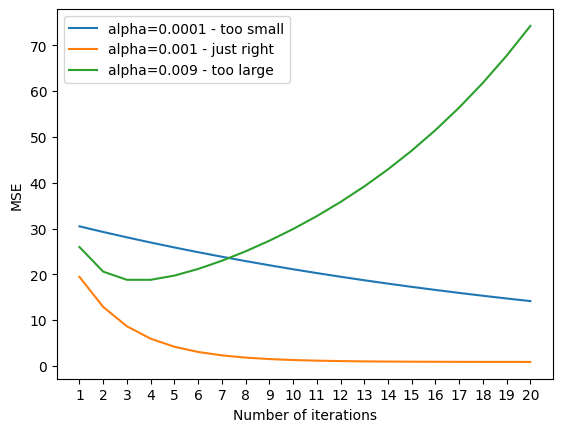

In [25]:
def compute_mse(X, beta, y):
    """Return the MSE between y_true and y_pred."""
    return np.mean((y - X @ beta) ** 2)

# We can create a simple dataset JUST FOR THIS EXAMPLE
def create_dataset():
    np.random.seed(0)
    n_features = 3
    n_samples = 100
    X = np.random.randn(n_samples, n_features)
    X_expanded = np.hstack(
        [np.ones((n_samples, 1)), X]
    )  # add a column of ones for the intercept term
    beta_true = [1, 2, 3, 4]
    y = X_expanded @ np.array(beta_true) + np.random.randn(n_samples)
    y = y.reshape(-1, 1)
    return X, y


X, y = create_dataset()
n_samples, n_features = X.shape
X_expanded = np.hstack([np.ones((n_samples, 1)), X])

# Learning rates to test
alphas = [0.0001, 0.001, 0.009]  # too small, just right, too large
lambda_ = 0.1
tol = 1e-6
max_iter = 20 #POCHE ITERAZIONI

# Train LASSO
all_errors = []
for learning_rate in alphas:
    errors = []
    beta = np.random.randn(n_features + 1, 1)   # initialize β with random normal values. We include the intercept term in β.
    i = 0
    beta_difference = tol + 1
    while i < max_iter and beta_difference > tol:
        gradient = lasso_gradient(X_expanded, y, beta, lambda_)
        beta_new = GD_update(beta, learning_rate, gradient)
        beta_difference = np.linalg.norm(beta_new - beta)  # to check the stopping criterion
        beta = beta_new
        error = compute_mse(X_expanded, beta, y) # erroe = MSE
        errors.append(error) # così vedo se gli errori crescono o diminuiscono
        i = 1 + i
    all_errors.append(errors)

# Plot
a = np.array(all_errors)
n_iters = a.shape[1]
x = np.arange(n_iters) + 1
plt.plot(x, a[0, :], label=f"alpha={alphas[0]} - too small")
plt.plot(x, a[1, :], label=f"alpha={alphas[1]} - just right")
plt.plot(x, a[2, :], label=f"alpha={alphas[2]} - too large")
plt.xticks(x)
plt.xlabel("Number of iterations")
plt.ylabel("MSE")
plt.legend()

## Nested Cross Validation

![image.png](https://vitalflux.com/wp-content/uploads/2020/08/Screenshot-2020-08-30-at-6.33.47-PM-300x198.png)

0. Define hyperparameter combinations  

1. Divide the dataset into K folds  

2. **Outer loop**: For fold $k_i$ in K

   1. Select fold $k_i$ as the <font color="#1F77B4"><strong>test set</strong></font> and the remaining as <font color="#818791"><strong>train set</strong></font>.  

   2. **Hyper param loop** For each combination <font color="#2CA02C"><strong>C</strong></font> of hyperparameters:  

      1. Divide the <font color="#818791"><strong>train set</strong></font> into D folds.

      2. **Inner loop**: For fold $d_j$ in D:  

         a. Select fold $d_j$ as <font color="#D35400"><strong>validation set</strong></font> and the remaining as <font color="#818791"><strong>inner train set</strong></font>.  

         b. Train the model using combination of hyperparams <font color="#2CA02C"><strong>C</strong></font> and using the <font color="#818791"><strong>inner train set</strong></font>.  

         c. Evaluate the performance on the <font color="#D35400"><strong>validation set</strong></font>.  

      3. Compute the average of the performance for <font color="#2CA02C"><strong>C</strong></font>.  

   3. Select the combination <font color="#2CA02C"><strong>C</strong></font> with the best performance.  

   4. Train the model using <font color="#2CA02C"><strong>C</strong></font> and the <font color="#818791"><strong>train set</strong></font>.  

   5. Evaluate the performance on the <font color="#1F77B4"><strong>test set</strong></font>.  

3. Aggregate the performances over the K folds (e.g., compute average and std).  

4. The best hyperparameters combination is the mean/mode of the best combinations obtained.  

5. Retrain a new model using the entire dataset and the best hyperparameter combination.

## Nested Cross Validation for LASSO on real dataset

Let's implement the procedure above.

In [27]:
# Load data
data = pd.read_csv("drive/MyDrive/AA24-25ML/prostate.csv")
display(data.head())

X = data.drop(columns=["lpsa"]).to_numpy()             # we drop the the lpsa column that we use as target
y = data[["lpsa"]].to_numpy()

# always check the shape of the data to be consistent
print("X.shape:", X.shape)
print("y.shape:", y.shape)

n_samples = X.shape[0]
n_features = X.shape[1]

FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/AA24-25ML/prostate.csv'

In [ ]:
# 0. Define the hyperparameters combinations
alphas = [0.00001, 0.0001, 0.001, 0.01]
lambdas_ = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
hyperparams_comb = [(alpha, lambda_) for alpha in alphas for lambda_ in lambdas_]

print("Number of alphas:", len(alphas))
print("Number of lambdas:", len(lambdas_))
print("Number of hyperparameters combinations:", len(hyperparams_comb))
print("Hyperparameters combinations:", hyperparams_comb)

In [ ]:
# 1. Split the data into K folds
K = 8
fold_size = n_samples // K

# K-fold CV assign each sample to a fold randomly. The easiest way to do this is to shuffle
# the data and then divide it into K equal parts, each one containing fold_size samples.
shuffled_indices = np.random.permutation(n_samples)
X_shuffled = X[shuffled_indices]
y_shuffled = y[shuffled_indices]

In [ ]:
n_max_iter_GD = 1000
mse_values = []             # to store performance values across folds
r2_values = []              # to store performance values across folds

# 2. Outer loop: for each fold
for i in range(K):

    # take i-th fold as test set and the rest as training set
    start_test = i * fold_size
    end_test = (i + 1) * fold_size
    X_test = X_shuffled[start_test:end_test]
    y_test = y_shuffled[start_test:end_test]
    X_train = np.concatenate([X_shuffled[:start_test], X_shuffled[end_test:]])
    y_train = np.concatenate([y_shuffled[:start_test], y_shuffled[end_test:]])

    # 1. Iterate over the possible combinations of hyperparameters to take the best one
    best_combination = (0, 0)                       # starting values
    best_mse = np.inf                               # starting values

    for alpha, lambda_ in hyperparams_comb:
        # Inner-loop: cross validation to select the best hyperparameters combination (the one with lowest mse)
        # 1. Divide the training set into D folds
        D = 4
        n_samples_in_X_train = X_train.shape[0]
        D_fold_size = n_samples_in_X_train // D

        mse_inner_values = []
        for j in range(D):
            # a. take j-th fold as validation set and the rest as training set
            start_val = j * D_fold_size
            end_val = (j + 1) * D_fold_size
            X_val = X_train[start_val:end_val]
            y_val = y_train[start_val:end_val]
            X_inner_train = np.concatenate([X_train[:start_val], X_train[end_val:]])
            y_innter_train = np.concatenate([y_train[:start_val], y_train[end_val:]])

            # standardize the data (using the X_inner_train set)
            X_inner_train_mean = np.mean(X_inner_train, axis=0)
            X_inner_train_std = np.std(X_inner_train, axis=0)
            X_inner_train = (X_inner_train - X_inner_train_mean) / X_inner_train_std
            X_val = (X_val - X_inner_train_mean) / X_inner_train_std

            # b. Find the coefficients of the LASSO model using the inner training set + the current hyperparameters combination
            beta_ = train_LASSO_with_GD(X_inner_train, y_innter_train, lambda_, alpha, n_max_iter_GD, 1e-6)

            # c. Evaluate the model on the validation set
            y_val_pred = beta_[0] + X_val @ beta_[1:]
            mse = np.mean((y_val - y_val_pred)**2)
            mse_inner_values.append(mse)

        # 2. Compute the average performance on the validation set
        mse_avg = np.mean(mse_inner_values)

        # if the current hyperparam combination is the best (i.e., lowest MSE), update the best combination and the best MSE
        if mse_avg < best_mse:
            best_combination = (alpha, lambda_)
            best_mse = mse_avg


    # 5. Select the best hyperparameters combination based on the average performance on the validation set
    best_alpha, best_lambda_ = best_combination
    print("Best hyperparameters combination for iteration ", i, " is: ", best_combination)

    # 6. Train LASSO using the training set + the best hyperparameters combination
    # standardize the data and add the intercept term
    X_train_mean = np.mean(X_train, axis=0)
    X_train_std = np.std(X_train, axis=0)
    X_train_scaled = (X_train - X_train_mean) / X_train_std
    X_test_scaled = (X_test - X_train_mean) / X_train_std
    X_train_scaled = np.concatenate([np.ones((X_train_scaled.shape[0], 1)), X_train_scaled], axis=1)
    X_test_scaled = np.concatenate([np.ones((X_test_scaled.shape[0], 1)), X_test_scaled], axis=1)

    beta = np.random.randn(n_features + 1, 1)
    for t in range(n_max_iter_GD):
        gradient = lasso_gradient(X_train_scaled, y_train, beta, best_lambda_)
        beta = GD_update(beta, best_alpha, gradient)

    # 7. Evaluate the model on the test set
    y_test_pred = X_test_scaled @ beta
    mse = np.mean((y_test - y_test_pred)**2)
    r2 = 1 - mse / np.var(y_test)

    mse_values.append(mse)
    r2_values.append(r2)

# 8. Aggregate performance metrics, plot boxplots
mse_list = np.array(mse_values)
r2_list = np.array(r2_values)

plt.subplot(1, 2, 1)
plt.boxplot(mse_list)
plt.title("MSE")
plt.subplot(1, 2, 2)
plt.boxplot(r2_list)
plt.title("R2")
plt.show()

### Adaptive Learning Rate
- Too high values of the learning rate -> the algorithm may miss the minimum and diverge.
- Too low values -> the convergence may be very slow.

Solution: use high values of the learning rate at the beginning, when beta is probably far from the optimal value, and decrease the learning rate incrementally.

Dynamic adjustment of the learning rate:
$$
\alpha_{t} = \frac{\alpha_0}{1+\gamma t}
$$
where:
- $ \alpha_0 $ is the initial learning rate
- $ t $ is the current iteration
- $ \gamma $ is a decay parameter

<span style="color:red"><strong>🏋️‍♀️ Exercise</strong></span>

Implement adaptive learning rate in the gradient descent algorithm.

Before, with alpha=0.009 the loss was divergent, but by decreasing the learning rate each epoch, we can stabilize the learning.

In [ ]:
X, y = create_dataset()
n_samples, n_features = X.shape
X_expanded = np.hstack([np.ones((n_samples, 1)), X])

# We set the parameters
alphas = 0.009
lambda_ = 0.1
tol = 1e-6
max_iter = 20

# Train LASSO (static learning rate)
beta = np.random.randn(n_features + 1, 1)                           # initialize β with random normal values. We include the intercept term in β.
i = 0
beta_difference = tol + 1

#errors relative to the static learning rate implementation
static_errors = []
while i < max_iter and beta_difference > tol:
    gradient = lasso_gradient(X_expanded, y, beta, lambda_)
    beta_new = GD_update(beta, learning_rate, gradient)
    beta_difference = np.linalg.norm(beta_new - beta)               # to check the stopping criterion
    beta = beta_new
    error = compute_mse(X_expanded, beta, y)
    static_errors.append(error)
    i = 1 + i

# Train LASSO (adaptive learning rate)
beta = np.random.randn(n_features + 1, 1)                           # initialize β with random normal values. We include the intercept term in β.
i = 0
beta_difference = tol + 1
decay_rate=0.9

#errors relative to the static learning rate implementation
adaptive_errors = []
while i < max_iter and beta_difference > tol:
    ...
    error = compute_mse(X_expanded, beta, y)
    adaptive_errors.append(error)
    i = 1 + i


# Plot
plt.plot(static_errors, label=f"Static learning rate")
plt.plot(adaptive_errors, label=f"Adaptive learning rate")
plt.xlabel("Number of iterations")
plt.ylabel("MSE")
plt.legend()